In [ ]:
%pip install sentence-transformers==3.1.1
%pip install datasets
%pip install polars
%pip install torch
%pip install datasets
%pip install transformers==4.45.2
%pip install matplotlib
%pip install accelerate

# Importing Libraries

In [17]:
import polars as pl
from sentence_transformers import SentenceTransformer, losses, SentenceTransformerTrainer, SentenceTransformerTrainingArguments, InputExample
from transformers import TrainerCallback
import matplotlib.pyplot as plt
from datasets import Dataset
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator, SimilarityFunction

import os
os.environ["WANDB_DISABLED"] = "true"

# Data Processing 

In [ ]:
def remove_punctuation(df, col):
    return df.with_columns(
        pl.col(col).str.replace_all(r"[^\w\s]", "")
    )

In [ ]:
def lowercase(df, col):
    return df.with_columns(
        pl.col(col).str.to_lowercase()
    )

# Reading the Data

In [ ]:
def dataset(lang, test=False):
    if test:
        return pl.read_parquet(f"hf://datasets/SemRel/SemRel2024/{lang}/test-*")
    else:
        try:
            return pl.read_parquet(f"hf://datasets/SemRel/SemRel2024/{lang}/train-*")
        except:
            return pl.read_parquet(f"hf://datasets/SemRel/SemRel2024/{lang}/dev-*")

In [ ]:
languages = [
    "afr",
    "arq",
    "amh",
    "eng",
    "hau",
    "ind",
    "hin",
    "kin",
    "mar",
    "arb",
    "ary",
    "pan",
    "esp",
    "tel",
]

def read_datasets(test=False):
    datasets_train = {}
    for lang in languages:
        # Load language-specific dataset
        print("Loading langauge:", lang)
        
        df = dataset(lang, test=test)
        df = remove_punctuation(df, 'sentence1')
        df = remove_punctuation(df, 'sentence2')
        df = lowercase(df, 'sentence1')
        df = lowercase(df, 'sentence2')

        datasets_train[lang] = df

    return datasets_train

def read_dataset():
    df = dataset('*')
    df = remove_punctuation(df, 'sentence1')
    df = remove_punctuation(df, 'sentence2')
    df = lowercase(df, 'sentence1')
    df = lowercase(df, 'sentence2')

    return df

# Using SBERT

In [ ]:
def get_model():
    # Load the multilingual SBERT model
    model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')
    print(model.device)

    return model

def train_model(model, train_data, batch_size=32, num_epochs=5):
    training = []
    for row in train_data.iter_rows(named=True):
        training.append(InputExample(
            texts=[row['sentence1'], row['sentence2']],
            label=row['label']
        ))

    # Loss function
    train_loss = losses.CosineSimilarityLoss(model=model)

    # dataset
    dataset = Dataset.from_pandas(train_data.to_pandas())

    args = SentenceTransformerTrainingArguments(
        # Required parameter:
        output_dir="checkpoints",
        logging_dir="logs",
        logging_steps=10,
        # Optional training parameters:
        num_train_epochs=num_epochs,
        per_device_train_batch_size=batch_size,
        fp16=False,  # Set to False if you get an error that your GPU can't run on FP16
        save_strategy="steps",
        save_steps=100,
        save_total_limit=2,
    )

    class LossLogger(TrainerCallback):
        def __init__(self):
            super().__init__()
            self.loss_values = []

        def on_log(self, args, state, control, logs=None, **kwargs):
            if logs is not None:
                self.loss_values.append(logs.get('loss'))
                print(f"Step {state.global_step} - Loss: {logs.get('loss', 'N/A')}")

    logger = LossLogger()

    trainer = SentenceTransformerTrainer(
        model=model,
        args=args,
        train_dataset=dataset,
        loss=train_loss,
        callbacks=[logger]
    )
    trainer.train()

    return logger.loss_values

In [ ]:
train_datasets = read_datasets()
test_datasets = read_datasets(test=True)

In [ ]:
def prepare_test_data(test_data):
    # Extract columns from the Polars DataFrame
    sentences1 = test_data['sentence1'].to_list()
    sentences2 = test_data['sentence2'].to_list()
    labels = test_data['label'].to_list()
    
    return sentences1, sentences2, labels

def evaluate(model):
    results = {}
    for lang in test_datasets:
        print("Testing lang:", lang)

        sentences1, sentences2, labels = prepare_test_data(test_datasets[lang])

        # Create an evaluator
        evaluator = EmbeddingSimilarityEvaluator(sentences1, sentences2, labels)

        # Evaluate the model
        scores = evaluator(model)

        # Print the evaluation metrics
        print(scores)

        results[lang] = scores
        
    return results

In [ ]:
loss_values = []
results = {}

model = get_model()
results['base'] = evaluate(model)

for lang in languages:
    print("Training lang:", lang)
    loss_values.extend(train_model(model, train_datasets[lang], batch_size=32))

    results[lang] = evaluate(model)

# For Saving Results in Google Colab

In [ ]:
from google.colab import drive
import json

drive.mount('/content/drive')

with open('/content/drive/COS802/results.json') as file:
    json.dump(file, results)
with open('/content/drive/COS802/loss_values.json') as file:
    json.dump(file, loss_values)

# Visualizations

In [56]:
import json

with open('./results/results.json') as file:
    data = json.load(file)

data

{'base': {'afr': {'pearson_cosine': 0.7184301975645697,
   'spearman_cosine': 0.6997223797591405,
   'pearson_manhattan': 0.6034539577579113,
   'spearman_manhattan': 0.6036337214489862,
   'pearson_euclidean': 0.6041446597771711,
   'spearman_euclidean': 0.603840070577794,
   'pearson_dot': 0.6383232969132064,
   'spearman_dot': 0.6719802653723573,
   'pearson_max': 0.7184301975645697,
   'spearman_max': 0.6997223797591405},
  'arq': {'pearson_cosine': 0.24933061632856252,
   'spearman_cosine': 0.2509681402703508,
   'pearson_manhattan': 0.18287747691098366,
   'spearman_manhattan': 0.21622792839173738,
   'pearson_euclidean': 0.18042267250591984,
   'spearman_euclidean': 0.21785963144078693,
   'pearson_dot': 0.1429917850568489,
   'spearman_dot': 0.18339753423395574,
   'pearson_max': 0.24933061632856252,
   'spearman_max': 0.2509681402703508},
  'amh': {'pearson_cosine': 0.41164249897224797,
   'spearman_cosine': 0.4225032615618475,
   'pearson_manhattan': 0.4427919892768684,
   's

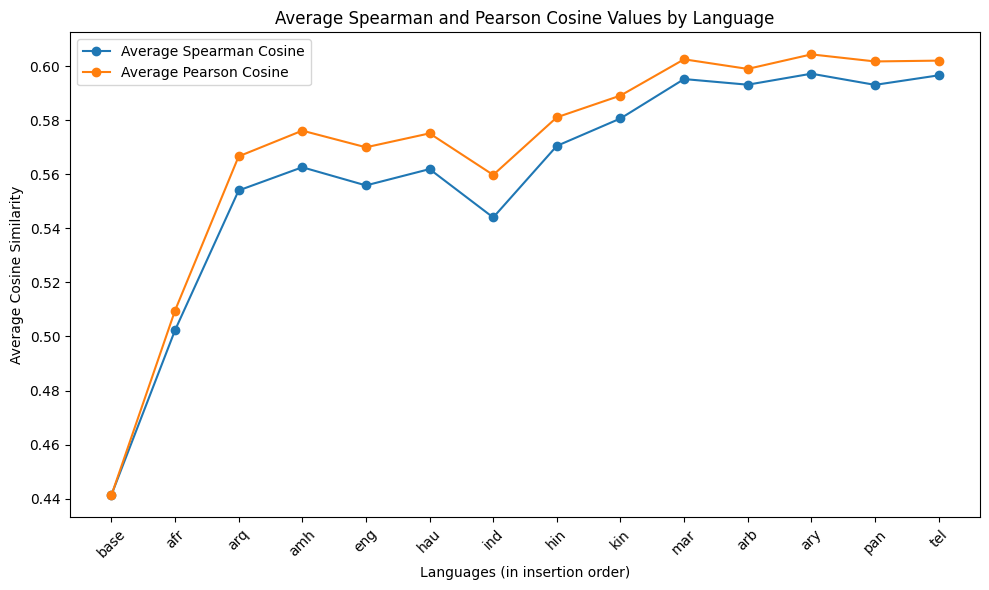

In [48]:
# Replace this with your dictionary
languages = data 

# Lists to store averages and labels
avg_spearman_values = []
avg_pearson_values = []
labels = []

# Iterate through the top-level keys in insertion order
for lang, pairs in languages.items():
    spearman_total = 0
    pearson_total = 0
    count = 0
    
    # Sum values across nested dictionaries
    for other_lang, values in pairs.items():
        if other_lang == "esp":
            continue
        spearman_total += values['spearman_cosine']
        pearson_total += values['pearson_cosine']
        count += 1
    
    # Calculate averages
    avg_spearman = spearman_total / count if count > 0 else 0
    avg_pearson = pearson_total / count if count > 0 else 0
    
    # Append averages and label
    avg_spearman_values.append(avg_spearman)
    avg_pearson_values.append(avg_pearson)
    labels.append(lang)

# Plotting the line graph
plt.figure(figsize=(10, 6))
plt.plot(labels, avg_spearman_values, label="Average Spearman Cosine", marker='o')
plt.plot(labels, avg_pearson_values, label="Average Pearson Cosine", marker='o')
plt.xlabel("Languages (in insertion order)")
plt.ylabel("Average Cosine Similarity")
plt.title("Average Spearman and Pearson Cosine Values by Language")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


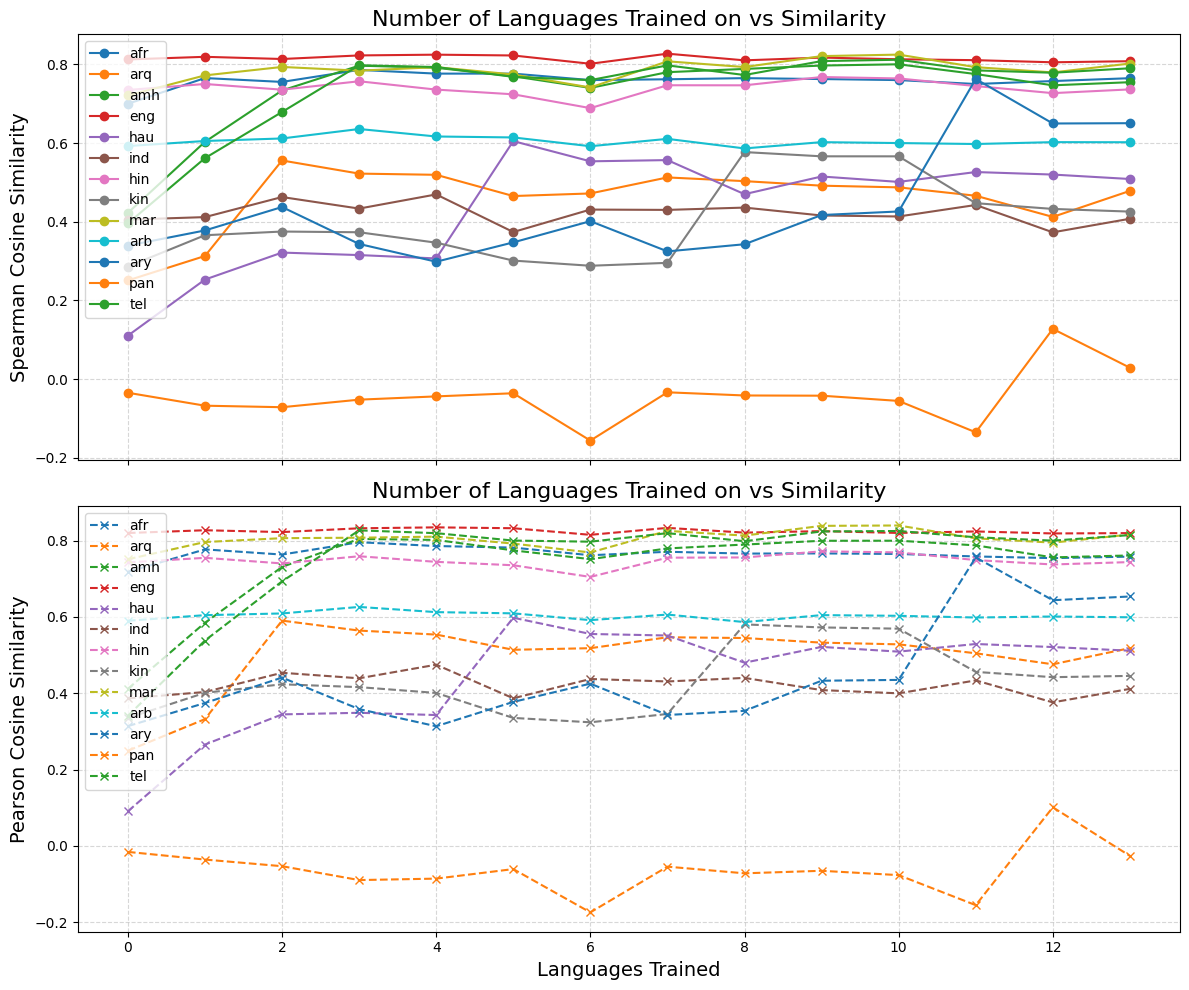

In [49]:
from collections import defaultdict

languages_data = defaultdict(lambda: {'spearman_cosine': [], 'pearson_cosine': []})

for entry in data.values():
    for lang, values in entry.items():
        languages_data[lang]['spearman_cosine'].append(values['spearman_cosine'])
        languages_data[lang]['pearson_cosine'].append(values['pearson_cosine'])

# Step 2: Set up the subplots for Spearman and Pearson
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Plotting Spearman cosine similarities
for lang, metrics in languages_data.items():
    ax1.plot(metrics['spearman_cosine'], label=lang, marker='o')
ax1.set_ylabel("Spearman Cosine Similarity", fontsize=14)
ax1.set_title("Number of Languages Trained on vs Similarity", fontsize=16)
ax1.legend(loc='upper left', fontsize=10)
ax1.grid(True, linestyle='--', alpha=0.5)

# Plotting Pearson cosine similarities
for lang, metrics in languages_data.items():
    ax2.plot(metrics['pearson_cosine'], label=lang, linestyle='--', marker='x')
ax2.set_xlabel("Languages Trained", fontsize=14)
ax2.set_ylabel("Pearson Cosine Similarity", fontsize=14)
ax2.set_title("Number of Languages Trained on vs Similarity", fontsize=16)
ax2.legend(loc='upper left', fontsize=10)
ax2.grid(True, linestyle='--', alpha=0.5)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


In [57]:
latex_code = r"""\begin{table}[h!]
\centering
\begin{tabular}{|c|c|c|}
\hline
Language & Spearman Cosine & Pearson Cosine \\
\hline
"""

# Populate rows with dictionary values
spearman_total = 0
pearson_total = 0
for lang, metrics in data['base'].items():
    if lang != 'esp':
        spearman_total += metrics['spearman_cosine']
        pearson_total += metrics['pearson_cosine']
    latex_code += f"{lang} & {metrics['spearman_cosine']:.2f} & {metrics['pearson_cosine']:.2f} \\\\\n"
    latex_code += r"\hline" + "\n"

latex_code += f"Average & {(spearman_total / len(data['tel'])):.2f} & {(pearson_total / len(data['tel'])):.2f} \\\\\n"
latex_code += r"\hline" + "\n"

# End of LaTeX table code
latex_code += r"""\end{tabular}
\caption{Cosine Similarity Results by Language Before Fine Tunining}
\label{tab:results}
\end{table}
"""

# Output the LaTeX code
print(latex_code)

\begin{table}[h!]
\centering
\begin{tabular}{|c|c|c|}
\hline
Language & Spearman Cosine & Pearson Cosine \\
\hline
afr & 0.70 & 0.72 \\
\hline
arq & 0.25 & 0.25 \\
\hline
amh & 0.42 & 0.41 \\
\hline
eng & 0.81 & 0.82 \\
\hline
hau & 0.11 & 0.09 \\
\hline
ind & 0.41 & 0.39 \\
\hline
hin & 0.73 & 0.74 \\
\hline
kin & 0.29 & 0.34 \\
\hline
mar & 0.72 & 0.75 \\
\hline
arb & 0.59 & 0.59 \\
\hline
ary & 0.34 & 0.31 \\
\hline
pan & -0.03 & -0.02 \\
\hline
esp & nan & nan \\
\hline
tel & 0.40 & 0.34 \\
\hline
Average & 0.41 & 0.41 \\
\hline
\end{tabular}
\caption{Cosine Similarity Results by Language Before Fine Tunining}
\label{tab:results}
\end{table}



In [51]:
latex_code = r"""\begin{table}[h!]
\centering
\begin{tabular}{|c|c|c|}
\hline
Language & Spearman Cosine & Pearson Cosine \\
\hline
"""

# Populate rows with dictionary values
spearman_total = 0
pearson_total = 0
for lang, metrics in data['tel'].items():
    if lang != 'esp':
        spearman_total += metrics['spearman_cosine']
        pearson_total += metrics['pearson_cosine']
    latex_code += f"{lang} & {metrics['spearman_cosine']:.2f} & {metrics['pearson_cosine']:.2f} \\\\\n"
    latex_code += r"\hline" + "\n"

latex_code += f"Average & {(spearman_total / len(data['tel'])):.2f} & {(pearson_total / len(data['tel'])):.2f} \\\\\n"
latex_code += r"\hline" + "\n"

# End of LaTeX table code
latex_code += r"""\end{tabular}
\caption{Cosine Similarity Results by Language After Fine Tunining}
\label{tab:results}
\end{table}
"""

# Output the LaTeX code
print(latex_code)

\begin{table}[h!]
\centering
\begin{tabular}{|c|c|c|}
\hline
Language & Spearman Cosine & Pearson Cosine \\
\hline
afr & 0.76 & 0.76 \\
\hline
arq & 0.48 & 0.52 \\
\hline
amh & 0.75 & 0.76 \\
\hline
eng & 0.81 & 0.82 \\
\hline
hau & 0.51 & 0.51 \\
\hline
ind & 0.41 & 0.41 \\
\hline
hin & 0.74 & 0.74 \\
\hline
kin & 0.43 & 0.45 \\
\hline
mar & 0.80 & 0.82 \\
\hline
arb & 0.60 & 0.60 \\
\hline
ary & 0.65 & 0.65 \\
\hline
pan & 0.03 & -0.03 \\
\hline
tel & 0.79 & 0.81 \\
\hline
Average & 0.60 & 0.60 \\
\hline
\end{tabular}
\caption{Cosine Similarity Results by Language After Fine Tunining}
\label{tab:results}
\end{table}



In [58]:
with open('./results/loss_values.json') as file:
    loss_values = json.load(file)

loss_values

[0.0295,
 0.0183,
 0.0083,
 0.0059,
 0.0043,
 0.004,
 None,
 0.031,
 0.0257,
 0.0256,
 0.0209,
 0.0113,
 0.0103,
 0.0107,
 0.0119,
 0.0076,
 0.0064,
 0.0064,
 0.0077,
 0.0042,
 0.0049,
 0.0056,
 0.006,
 0.0039,
 0.0041,
 0.004,
 0.0048,
 None,
 0.034,
 0.0188,
 0.02,
 0.0113,
 0.0098,
 0.0092,
 0.0071,
 0.0054,
 0.0058,
 0.0046,
 0.004,
 0.0048,
 0.0044,
 0.0039,
 0.0039,
 None,
 0.0197,
 0.0191,
 0.0194,
 0.0177,
 0.0166,
 0.0158,
 0.0171,
 0.0159,
 0.0174,
 0.0158,
 0.0174,
 0.0154,
 0.0174,
 0.0155,
 0.0158,
 0.0148,
 0.0165,
 0.0083,
 0.0052,
 0.0063,
 0.0056,
 0.0054,
 0.0057,
 0.0058,
 0.0064,
 0.0062,
 0.0059,
 0.0057,
 0.0062,
 0.0067,
 0.0069,
 0.0061,
 0.0066,
 0.0065,
 0.0042,
 0.0029,
 0.0032,
 0.0031,
 0.003,
 0.003,
 0.003,
 0.0033,
 0.003,
 0.0032,
 0.0035,
 0.0033,
 0.0033,
 0.0034,
 0.0034,
 0.0038,
 0.0034,
 0.0026,
 0.0022,
 0.0021,
 0.0022,
 0.0022,
 0.0021,
 0.0022,
 0.002,
 0.0019,
 0.0022,
 0.0023,
 0.0019,
 0.0021,
 0.0021,
 0.0022,
 0.0023,
 0.0024,
 0.0018,
 0

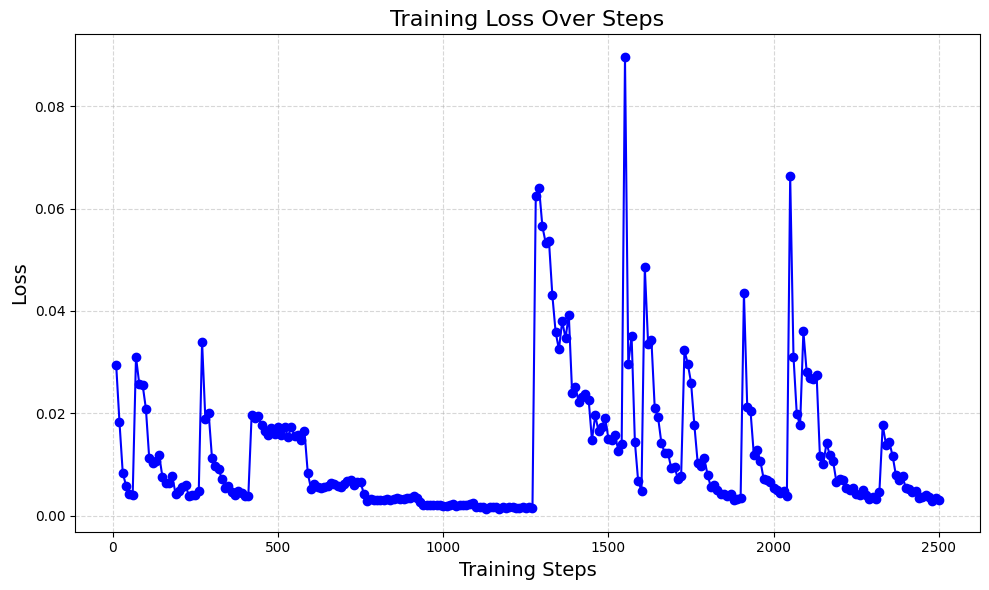

In [59]:
loss_values = list(filter(lambda val: val is not None, loss_values))
steps = list(range(10, 10 * (len(loss_values) + 1), 10))  # Generate step intervals based on every 10 steps

# Plotting the loss values
plt.figure(figsize=(10, 6))
plt.plot(steps, loss_values, marker='o', color='b', linestyle='-')
plt.xlabel("Training Steps", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.title("Training Loss Over Steps", fontsize=16)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

# Show the plot
plt.show()